In [25]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression, RidgeCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer,make_column_transformer
from sklearn import metrics

from my_functions import map_home, numeric_houses, dummy_houses, multiplier_attempt3

### Test and training csvs were provided for this project. 

In [26]:
df = pd.read_csv('../datasets/train.csv')
df.columns =df.columns.str.lower().str.replace(' ','_')


#### Taking a peek at the missing values in two ways

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               2051 non-null   int64  
 1   pid              2051 non-null   int64  
 2   ms_subclass      2051 non-null   int64  
 3   ms_zoning        2051 non-null   object 
 4   lot_frontage     1721 non-null   float64
 5   lot_area         2051 non-null   int64  
 6   street           2051 non-null   object 
 7   alley            140 non-null    object 
 8   lot_shape        2051 non-null   object 
 9   land_contour     2051 non-null   object 
 10  utilities        2051 non-null   object 
 11  lot_config       2051 non-null   object 
 12  land_slope       2051 non-null   object 
 13  neighborhood     2051 non-null   object 
 14  condition_1      2051 non-null   object 
 15  condition_2      2051 non-null   object 
 16  bldg_type        2051 non-null   object 
 17  house_style   

80 columns and the target,saleprice, Lots of data missing and different types. Lots  of cleaning to do.

In [28]:
features = list(df.columns)

In [29]:
missing_vals= [(df[features[i]].isna().mean(),features[i])for i in range(80)]

In [30]:
missing_vals.sort(key=lambda pair: pair[0], reverse= True)
missing_vals

[(0.9956118966357874, 'pool_qc'),
 (0.9683081423695759, 'misc_feature'),
 (0.931740614334471, 'alley'),
 (0.8049731838127743, 'fence'),
 (0.48756704046806437, 'fireplace_qu'),
 (0.16089712335446124, 'lot_frontage'),
 (0.05558264261335934, 'garage_yr_blt'),
 (0.05558264261335934, 'garage_finish'),
 (0.05558264261335934, 'garage_qual'),
 (0.05558264261335934, 'garage_cond'),
 (0.05509507557289127, 'garage_type'),
 (0.028278888347147733, 'bsmt_exposure'),
 (0.027303754266211604, 'bsmtfin_type_2'),
 (0.02681618722574354, 'bsmt_qual'),
 (0.02681618722574354, 'bsmt_cond'),
 (0.02681618722574354, 'bsmtfin_type_1'),
 (0.010726474890297415, 'mas_vnr_type'),
 (0.010726474890297415, 'mas_vnr_area'),
 (0.0009751340809361287, 'bsmt_full_bath'),
 (0.0009751340809361287, 'bsmt_half_bath'),
 (0.00048756704046806434, 'bsmtfin_sf_1'),
 (0.00048756704046806434, 'bsmtfin_sf_2'),
 (0.00048756704046806434, 'bsmt_unf_sf'),
 (0.00048756704046806434, 'total_bsmt_sf'),
 (0.00048756704046806434, 'garage_cars'),


<p>One major challenge in this project is that there are many columns that are missing for a significant number of houses.</p> 
<p>If it does not have the specific amenity the other columns describing its quality and condition - will they be null? zero?. </p> <p> I want to build a model that will not lose any information about the amenities or their condition.</p>

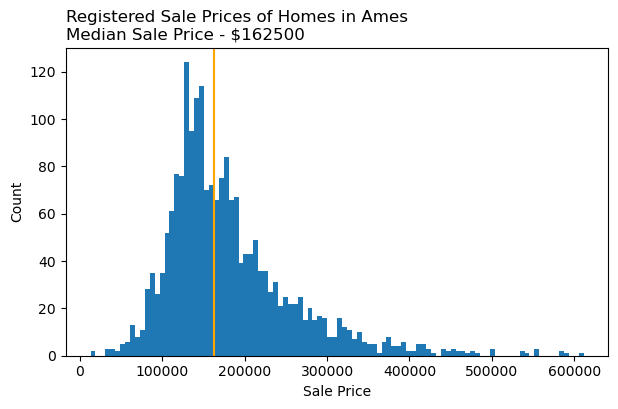

In [31]:
plt.figure(figsize=(7,4))
plt.hist(df['saleprice'], bins = 100)
plt.xlabel('Sale Price')
plt.ylabel('Count')
plt.axvline(np.median(df['saleprice']), color='orange')
plt.title('Registered Sale Prices of Homes in Ames \n'+ 
          'Median Sale Price - $162500',loc= 'left')
plt.savefig('../images/price_hist.png');

Typical quality columns have values like the ones below and I build a function that applies a map to each similar column that has ordinal values.

In [32]:
df['garage_qual'].value_counts()

TA    1832
Fa      82
Gd      18
Ex       3
Po       2
Name: garage_qual, dtype: int64

In [33]:
df1 = map_home(df.drop(columns=['saleprice']))
df2 = numeric_houses(df1)

In [34]:
df2.columns

Index(['pid', 'ms_subclass', 'ms_zoning', 'lot_frontage', 'lot_area', 'street',
       'alley', 'land_contour', 'utilities', 'lot_config', 'land_slope',
       'neighborhood', 'condition_1', 'condition_2', 'bldg_type',
       'house_style', 'overall_qual', 'overall_cond', 'year_built',
       'year_remod/add', 'roof_style', 'roof_matl', 'exterior_1st',
       'exterior_2nd', 'mas_vnr_type', 'mas_vnr_area', 'exter_qual',
       'exter_cond', 'foundation', 'bsmt_qual', 'bsmt_cond', 'bsmt_exposure',
       'bsmtfin_type_1', 'bsmtfin_sf_1', 'bsmtfin_type_2', 'bsmtfin_sf_2',
       'bsmt_unf_sf', 'total_bsmt_sf', 'heating', 'heating_qc', 'central_air',
       'electrical', '1st_flr_sf', '2nd_flr_sf', 'low_qual_fin_sf',
       'gr_liv_area', 'bsmt_full_bath', 'bsmt_half_bath', 'full_bath',
       'half_bath', 'bedroom_abvgr', 'kitchen_abvgr', 'kitchen_qual',
       'totrms_abvgrd', 'functional', 'fireplaces', 'fireplace_qu',
       'garage_type', 'garage_yr_blt', 'garage_finish', 'garage_car

In [35]:
df2.sample(12)

,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,land_contour,utilities,lot_config,...,screen_porch,pool_area,pool_qc,misc_feature,misc_val,mo_sold,yr_sold,sale_type,fence_private,fence_wood
559,907290230,120,RM,37.0,4435,Pave,NaN,Lvl,AllPub,Inside,...,0,0,0,NaN,0,5,2006,WD,0,0
495,903430050,50,RM,40.0,5680,Pave,Grvl,Lvl,AllPub,Inside,...,0,0,0,NaN,0,9,2007,WD,1,0
1136,527252070,20,RL,60.0,8089,Pave,NaN,HLS,AllPub,Inside,...,0,0,0,NaN,0,10,2007,New,0,0
1230,527359070,60,RL,80.0,10480,Pave,NaN,Lvl,AllPub,Inside,...,0,0,0,NaN,0,9,2008,WD,0,0
744,905200090,90,RL,60.0,12900,Pave,NaN,Lvl,AllPub,Inside,...,0,0,0,NaN,0,1,2008,WD,0,0
566,905103140,80,RL,96.0,11777,Pave,NaN,Lvl,AllPub,Inside,...,0,0,0,NaN,0,5,2006,WD,0,0
1707,902108060,70,RM,66.0,3960,Pave,Grvl,Lvl,AllPub,Inside,...,0,0,0,NaN,0,7,2006,WD,1,0
1858,907255050,20,RL,0.0,14781,Pave,NaN,Lvl,AllPub,CulDSac,...,0,0,0,NaN,0,8,2006,WD,0,0
1983,526351030,20,RL,87.0,11029,Pave,NaN,Lvl,AllPub,Corner,...,190,0,0,NaN,0,5,2008,WD,0,0
1432,923204140,90,RL,100.0,25000,Pave,NaN,Low,AllPub,Inside,...,0,0,0,NaN,0,6,2007,WD,0,0


In [36]:
X = df2.copy()

In [37]:
X_train,X_test,y_train,y_test = train_test_split(X,df['saleprice'],random_state=512)

## One hot Encoding categorical features

In [44]:
cat_features = ['mas_vnr_type','bsmt_exposure','garage_type','alley','misc_feature',
                'land_contour','ms_subclass','ms_zoning','street','neighborhood',
                'condition_2','bldg_type', 'house_style','roof_style','roof_matl',
                'exterior_1st','exterior_2nd','foundation',
               'central_air','electrical','sale_type','condition_1','utilities','lot_config','land_slope',
               'heating','paved_drive','mo_sold']
ct = ColumnTransformer([('oh', OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first'), cat_features)
], remainder='passthrough')

In [45]:
X_train_dummy = pd.DataFrame(ct.fit_transform(X_train),columns=ct.get_feature_names_out())
X_test_dummy = pd.DataFrame(ct.transform(X_test),columns=ct.get_feature_names_out())

c:\Users\seanh\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [4, 7, 14, 15, 19, 22] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [46]:
X_train_dummy.shape

(1538, 224)

In [47]:
X_test_dummy.shape

(513, 224)

For feature engineering I decided to make new columns that represent the presence of the specific amenity multiplied by a factor representing the effect of quality on value. I attempted that and made it standard in my .py file so it can be easily modified!

In [48]:
X_train_multiplied = multiplier_attempt3(X_train_dummy)
X_test_multiplied = multiplier_attempt3(X_test_dummy)

In [55]:
len(X_test_multiplied.columns)

234